In [1]:
import pandas as pd
import seaborn as sb

In [2]:
sb.set(rc={'figure.figsize':(20,15)}, style="darkgrid")

In [3]:
exps = {
    "batch_size": ["1", "10", "11", "12", "13"],
    "lr_critic": ["1", "20"]
}

dfs = []
for exp in exps:
    df = pd.concat(
        [pd.read_json(f"./hp_search_results/set{fid}_results.json").T[0].rolling(window=50).mean() for fid in exps[exp]],
        axis=1
    )
    df.columns = [f"set_{fid}" for fid in exps[exp]]
    dfs.append(df)


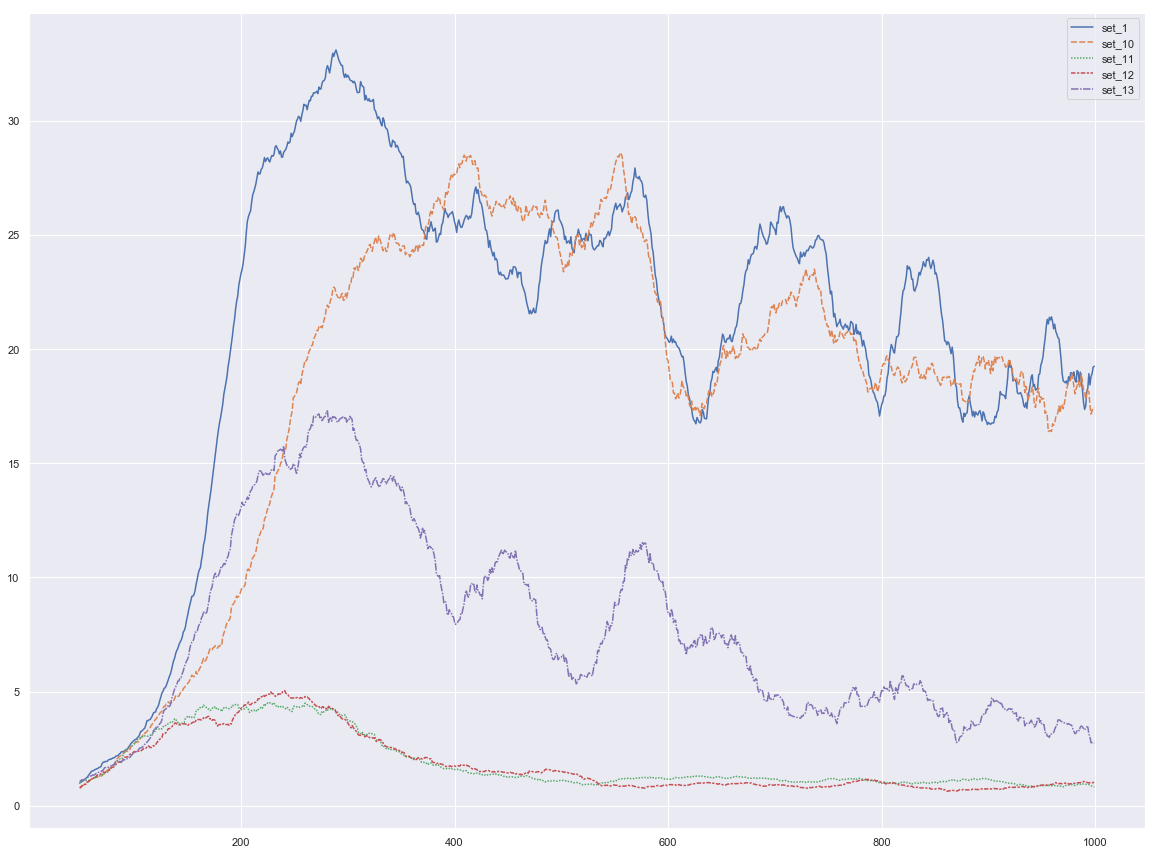

In [4]:
sb.lineplot(data = dfs[0])

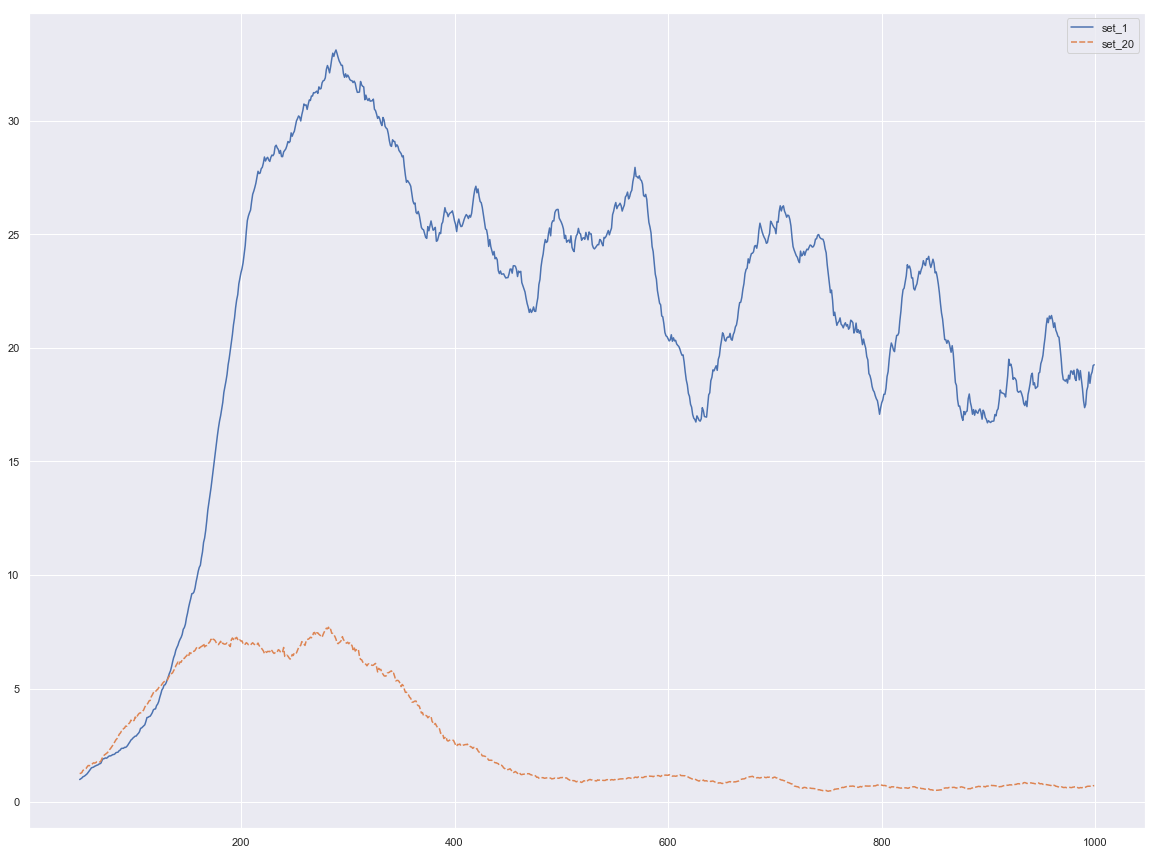

In [5]:
sb.lineplot(data = dfs[1])